In [1]:
from typing import *
import libcst as cst
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
from alkh import cst_utils

In [15]:
file_path = 'play.py'

In [16]:
file_lines = open(file_path, 'r').readlines()
file_content = open(file_path, 'r').read()
wrapper = cst.metadata.MetadataWrapper(cst.parse_module(file_content))
scopes = set(wrapper.resolve(cst.metadata.ScopeProvider).values())
ranges = wrapper.resolve(cst.metadata.PositionProvider)
file_number_of_lines = len(file_lines)

In [17]:
def get_range(scope, file_number_of_lines, ranges):
    if isinstance(scope, cst.metadata.scope_provider.GlobalScope):
        start_line_number = 1
        end_line_number = file_number_of_lines
        scope_name = 'global'
    else:
        start_line_number = ranges[scope.node].start.line
        end_line_number = ranges[scope.node].end.line
        scope_name = scope.name
    scope_length = end_line_number - start_line_number + 1
    values = [scope, start_line_number, end_line_number, scope_length, scope_name]
    names = ["scope", "start_line_number", "end_line_number", "length", "name"]
    output_series = pd.Series(values, index=names)
    return output_series

In [18]:
a = pd.Series(list(scopes)).to_frame('scope')
scopes_df = a["scope"].apply(get_range, args=(file_number_of_lines, ranges))
scopes_df["scope_index"] = range(len(scopes_df))
scopes_df

,scope,start_line_number,end_line_number,length,name,scope_index
0,<libcst.metadata.scope_provider.GlobalScope ob...,1,31,31,global,0
1,<libcst.metadata.scope_provider.ClassScope obj...,21,31,11,B,1
2,<libcst.metadata.scope_provider.ClassScope obj...,5,18,14,A,2
3,<libcst.metadata.scope_provider.FunctionScope ...,12,18,7,run,3
4,<libcst.metadata.scope_provider.FunctionScope ...,8,10,3,__init__,4
5,<libcst.metadata.scope_provider.FunctionScope ...,22,24,3,__init__,5
6,<libcst.metadata.scope_provider.FunctionScope ...,26,31,6,run,6


In [52]:
def _get_call_graph_with_df(wrapper, ranges, scopes_df) -> (nx.DiGraph, pd.DataFrame):
    ranges = wrapper.resolve(cst.metadata.PositionProvider)    
    visitor = FunctionCollector(ranges)    
    wrapper.visit(visitor)
    call_df = pd.DataFrame(visitor.get_info(), columns=['assigned', 'data', 'line'])
    call_df['assigner'] = call_df['data'].apply(lambda x: x['names'])
    call_df["scope_index"] = call_df["line"].apply(get_scope_index, args=(scopes_df,))
    call_df['hash_name'] = call_df.apply(lambda x: (x["assigned"], x["scope_index"]), axis=1)
    di_graph = _create_di_graph_from_call_df(call_df)
    return di_graph, call_df

class FunctionCollector(cst.CSTVisitor):
    METADATA_DEPENDENCIES = (cst.metadata.PositionProvider,)

    def __init__(self, ranges):
        super().__init__()
        self._ranges = ranges
        self._assign_info: List[Tuple] = []

    def get_info(self):
        return self._assign_info

    def visit_Assign(self, node: cst.FunctionDef) -> None:
        pos = self._ranges[node].start
        collector = ValueCollector()
        node.value.visit(collector)
        value_dict = {'names': collector.names, 'ints': collector.ints, 'floats': collector.floats}
        self._assign_info.append((node.targets[0].target.value, value_dict, pos.line))


class ValueCollector(cst.CSTVisitor):
    def __init__(self):
        super().__init__()
        self.names: List[str] = []
        self.ints: List[str] = []
        self.floats: List[str] = []

    def visit_Name(self, node: cst.FunctionDef) -> None:
        self.names.append(node.value)

    def visit_Integer(self, node: cst.FunctionDef) -> None:
        self.ints.append(node.value)

    def visit_Float(self, node: cst.FunctionDef) -> None:
        self.floats.append(node.value)

        
def _get_all_variables_names(call_df):
    assigned_list = list(call_df.apply(lambda x: (x["assigned"], x["scope_index"]), axis=1))
    assigners_list = list(call_df.explode(['assigner']).dropna().apply(lambda x: (x["assigner"], x["scope_index"]), axis=1))
    return set(assigned_list + assigners_list)


def _create_di_graph_from_call_df(call_df):
    var_names = _get_all_variables_names(call_df)
    di_graph = nx.DiGraph()
    for name in var_names:
        di_graph.add_node(name)
    for index, a_series in call_df.iterrows():
        scope_index = a_series["scope_index"]
        if a_series['assigner']:
            for assigner in a_series['assigner']:
                di_graph.add_edge((assigner, scope_index), (a_series['assigned'], scope_index))
    return di_graph

def get_scope_index(line_number, scopes_df):
    c = scopes_df.query(f"start_line_number <= {line_number} and end_line_number >= {line_number}").sort_values("length")
    scope_index = c.iloc[0]['scope_index']
    return scope_index

In [53]:
di_graph, call_df = _get_call_graph_with_df(wrapper, ranges, scopes_df)

In [54]:
call_df

,assigned,data,line,assigner,scope_index,hash_name
0,k,"{'names': [], 'ints': ['8'], 'floats': []}",6,[],2,"(k, 2)"
1,b,"{'names': ['self', 'k'], 'ints': ['8'], 'float...",9,"[self, k]",4,"(b, 4)"
2,a,"{'names': [], 'ints': ['5'], 'floats': []}",13,[],3,"(a, 3)"
3,b,"{'names': ['a'], 'ints': ['7'], 'floats': ['5....",14,[a],3,"(b, 3)"
4,ll,"{'names': ['a'], 'ints': [], 'floats': ['6.4']}",15,[a],3,"(ll, 3)"
5,c,"{'names': ['a', 'b'], 'ints': ['3'], 'floats':...",16,"[a, b]",3,"(c, 3)"
6,d,"{'names': ['b', 'c'], 'ints': [], 'floats': []}",17,"[b, c]",3,"(d, 3)"
7,k,"{'names': ['d'], 'ints': ['2'], 'floats': []}",18,[d],3,"(k, 3)"
8,b,"{'names': [], 'ints': ['8'], 'floats': []}",23,[],5,"(b, 5)"
9,a,"{'names': [], 'ints': ['5'], 'floats': []}",27,[],6,"(a, 6)"


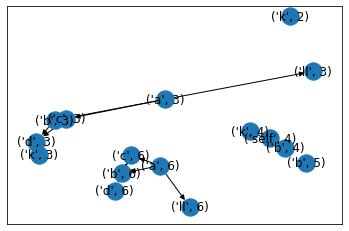

In [55]:
nx.draw_networkx(di_graph)

In [56]:
scopes_df

,scope,start_line_number,end_line_number,length,name,scope_index
0,<libcst.metadata.scope_provider.GlobalScope ob...,1,31,31,global,0
1,<libcst.metadata.scope_provider.ClassScope obj...,21,31,11,B,1
2,<libcst.metadata.scope_provider.ClassScope obj...,5,18,14,A,2
3,<libcst.metadata.scope_provider.FunctionScope ...,12,18,7,run,3
4,<libcst.metadata.scope_provider.FunctionScope ...,8,10,3,__init__,4
5,<libcst.metadata.scope_provider.FunctionScope ...,22,24,3,__init__,5
6,<libcst.metadata.scope_provider.FunctionScope ...,26,31,6,run,6


In [57]:
line_number = 17

In [58]:
a_series = call_df.query(f"line == {line_number}").iloc[0]
a_series

assigned                                                     d
data           {'names': ['b', 'c'], 'ints': [], 'floats': []}
line                                                        17
assigner                                                [b, c]
scope_index                                                  3
hash_name                                               (d, 3)
Name: 6, dtype: object

In [59]:
graph_node_name = a_series['hash_name']
graph_node_name

('d', 3)

In [60]:
ancestors = nx.ancestors(di_graph, graph_node_name)
ancestors

{('a', 3), ('b', 3), ('c', 3)}

In [61]:
call_df[call_df['hash_name'].isin(ancestors)]

,assigned,data,line,assigner,scope_index,hash_name
2,a,"{'names': [], 'ints': ['5'], 'floats': []}",13,[],3,"(a, 3)"
3,b,"{'names': ['a'], 'ints': ['7'], 'floats': ['5....",14,[a],3,"(b, 3)"
5,c,"{'names': ['a', 'b'], 'ints': ['3'], 'floats':...",16,"[a, b]",3,"(c, 3)"


# try3

In [66]:
class FunctionCollector(cst.CSTVisitor):
    METADATA_DEPENDENCIES = (cst.metadata.PositionProvider,)

    def __init__(self, ranges):
        super().__init__()
        self._ranges = ranges
        self._assign_info: List[Tuple] = []

    def get_info(self):
        return self._assign_info

    def visit_Assign(self, node: cst.FunctionDef) -> None:
        pos = self._ranges[node].start
        collector = ValueCollector()
        node.value.visit(collector)
        value_dict = {'names': collector.names, 'ints': collector.ints, 'floats': collector.floats}
        self._assign_info.append((node.targets[0].target.value, value_dict, pos.line))


class ValueCollector(cst.CSTVisitor):
    def __init__(self):
        super().__init__()
        self.names: List[str] = []
        self.ints: List[str] = []
        self.floats: List[str] = []

    def visit_Name(self, node: cst.FunctionDef) -> None:
        self.names.append(node.value)

    def visit_Integer(self, node: cst.FunctionDef) -> None:
        self.ints.append(node.value)

    def visit_Float(self, node: cst.FunctionDef) -> None:
        self.floats.append(node.value)

In [84]:
class CallGraphManager:
    def __init__(self, file_path):
        self._call_graph, self._call_df = self._get_call_graph_with_df(file_path)
        
    def get_variable_affecting_lines_numbers(self, line_number: str) -> List[int]:
        a_series = self._call_df.query(f"line == {line_number}").iloc[0]
        graph_node_name = a_series['hash_name']
        ancestors = nx.ancestors(self._call_graph, graph_node_name)       
        ancestors_df = self._get_ancestors_call_df(ancestors, graph_node_name)
        lines_numbers_list = self._get_lines_numbers_list(ancestors_df)
        return lines_numbers_list
    
    def _get_ancestors_call_df(self, ancestors, graph_node_name):
        return self._call_df[self._call_df['hash_name'].isin(ancestors.union({graph_node_name}))]
    
    @staticmethod
    def _get_lines_numbers_list(ancestors_df: pd.DataFrame):
        return list(ancestors_df['line'].values)
        
    def _get_call_graph_with_df(self, file_path: str) -> (nx.DiGraph, pd.DataFrame):
        file_lines = open(file_path, 'r').readlines()
        file_content = open(file_path, 'r').read()
        wrapper = cst.metadata.MetadataWrapper(cst.parse_module(file_content))
        scopes = set(wrapper.resolve(cst.metadata.ScopeProvider).values())
        ranges = wrapper.resolve(cst.metadata.PositionProvider)
        file_number_of_lines = len(file_lines)
        
        a = pd.Series(list(scopes)).to_frame('scope')
        scopes_df = a["scope"].apply(self._get_range, args=(file_number_of_lines, ranges))
        scopes_df["scope_index"] = range(len(scopes_df))
        
        di_graph, call_df = self._get_call_graph_with_df_from_objects(wrapper, ranges, scopes_df)
        return di_graph, call_df
        
    def _get_range(self, scope, file_number_of_lines, ranges):
        if isinstance(scope, cst.metadata.scope_provider.GlobalScope):
            start_line_number = 1
            end_line_number = file_number_of_lines
            scope_name = 'global'
        else:
            start_line_number = ranges[scope.node].start.line
            end_line_number = ranges[scope.node].end.line
            scope_name = scope.name
        scope_length = end_line_number - start_line_number + 1
        values = [scope, start_line_number, end_line_number, scope_length, scope_name]
        names = ["scope", "start_line_number", "end_line_number", "length", "name"]
        output_series = pd.Series(values, index=names)
        return output_series
    
    def _get_call_graph_with_df_from_objects(self, wrapper, ranges, scopes_df) -> (nx.DiGraph, pd.DataFrame):
        ranges = wrapper.resolve(cst.metadata.PositionProvider)    
        visitor = FunctionCollector(ranges)    
        wrapper.visit(visitor)
        call_df = pd.DataFrame(visitor.get_info(), columns=['assigned', 'data', 'line'])
        call_df['assigner'] = call_df['data'].apply(lambda x: x['names'])
        call_df["scope_index"] = call_df["line"].apply(self._get_scope_index, args=(scopes_df,))
        call_df['hash_name'] = call_df.apply(lambda x: (x["assigned"], x["scope_index"]), axis=1)
        di_graph = self._create_di_graph_from_call_df(call_df)
        return di_graph, call_df
    
    def _get_all_variables_names(self, call_df):
        assigned_list = list(call_df.apply(lambda x: (x["assigned"], x["scope_index"]), axis=1))
        assigners_list = list(call_df.explode(['assigner']).dropna().apply(lambda x: (x["assigner"], x["scope_index"]), axis=1))
        return set(assigned_list + assigners_list)


    def _create_di_graph_from_call_df(self, call_df):
        var_names = self._get_all_variables_names(call_df)
        di_graph = nx.DiGraph()
        for name in var_names:
            di_graph.add_node(name)
        for index, a_series in call_df.iterrows():
            scope_index = a_series["scope_index"]
            if a_series['assigner']:
                for assigner in a_series['assigner']:
                    di_graph.add_edge((assigner, scope_index), (a_series['assigned'], scope_index))
        return di_graph

    def _get_scope_index(self, line_number, scopes_df):
        c = scopes_df.query(f"start_line_number <= {line_number} and end_line_number >= {line_number}").sort_values("length")
        scope_index = c.iloc[0]['scope_index']
        return scope_index

In [85]:
mm = CallGraphManager('play.py')

In [86]:
mm.get_variable_affecting_lines_numbers(17)

[13, 14, 16, 17]